In [1]:
import torch
from diffusers import StableDiffusion3Pipeline
import diffusers


# model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
model_id = "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671"
pipe = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [25]:
from diffusers.utils.transformer_split_config import TransformerSplitConfig
    
# transformer_split1_host = '96.245.177.234'
# transformer_split1_port = 8765

# transformer_split2_host = '96.245.177.234' 
# transformer_split2_port = 8766

# transformer_split1_host = '0.0.0.0'
# transformer_split1_port = 1234

# transformer_split2_host = '0.0.0.0' 
# transformer_split2_port = 5678

transformer_split1_host = ['0.0.0.0','96.245.177.234']
transformer_split1_port = [1234, 8767]

transformer_split2_host = ['0.0.0.0','96.245.177.234']
transformer_split2_port = [5678, 8768]

# transformer_split1_host = ['0.0.0.0','96.245.177.234','96.245.177.234']
# transformer_split1_port = [1234, 8765, 8767]

# transformer_split2_host = ['0.0.0.0','96.245.177.234','96.245.177.234']
# transformer_split2_port = [5678, 8766, 8768]

# Create an instance of TransformerSplitConfig
split_config = TransformerSplitConfig(
    num_splits=2,
    hosts=[transformer_split1_host, transformer_split2_host],
    ports=[transformer_split1_port, transformer_split2_port],
    pipe_config=pipe.transformer.config,
    redundant_distributed_servers=True,
    validation_threshold=0.9
)



In [26]:
pipe.transformer.config

FrozenDict([('sample_size', 128),
            ('patch_size', 2),
            ('in_channels', 16),
            ('num_layers', 24),
            ('attention_head_dim', 64),
            ('num_attention_heads', 24),
            ('joint_attention_dim', 4096),
            ('caption_projection_dim', 1536),
            ('pooled_projection_dim', 2048),
            ('out_channels', 16),
            ('pos_embed_max_size', 192),
            ('_class_name', 'SD3Transformer2DModel'),
            ('_diffusers_version', '0.29.0.dev0'),
            ('_name_or_path',
             '/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671/transformer')])

In [27]:
from diffusers import StableDiffusion3PipelineSplitClientSocket

from diffusers.models.transformers.transformer_sd3_split import SD3Transformer2DModelClientSplit


part1_blocks = pipe.transformer.transformer_blocks[0]

time_text_embed_state_dict = pipe.transformer.time_text_embed.state_dict()
context_embedder_state_dict = pipe.transformer.context_embedder.state_dict()
pos_embed_state_dict = pipe.transformer.pos_embed.state_dict()

transformer_client_split = SD3Transformer2DModelClientSplit(pipe.transformer.config, part1_blocks, time_text_embed_state_dict, context_embedder_state_dict, pos_embed_state_dict).half()

split_pipe = StableDiffusion3PipelineSplitClientSocket(
    	transformer_client_split =transformer_client_split,
    	transformer_server_split_config=split_config,
        scheduler = pipe.scheduler,
        vae = pipe.vae,
        text_encoder = pipe.text_encoder,
        tokenizer= pipe.tokenizer,
        text_encoder_2 = pipe.text_encoder_2,
        tokenizer_2=pipe.tokenizer_2,
        text_encoder_3=pipe.text_encoder_3,
        tokenizer_3= pipe.tokenizer_3,)

In [28]:
split_pipe = split_pipe.to("cuda:4")

  0%|          | 0/28 [00:00<?, ?it/s]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.96875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.96875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.96875
1.0
1.0


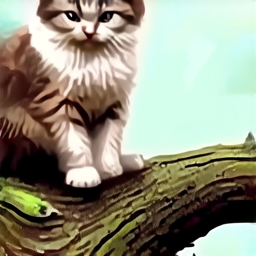

In [30]:
image = split_pipe(
    # "High quality portrait suited to put in LinkedIn of a anthromorphic bunny",
	"Oil painting of a cat sitting on a tree",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    height = 256, 
    width = 256
).images[0]
image

In [9]:
hash_compare_time_512= [0.04575157165527344, 0.009451866149902344, 0.04182147979736328, 0.010096549987792969, 0.042221784591674805, 0.009093999862670898, 0.041069746017456055, 0.009338140487670898, 0.05159878730773926, 0.009608030319213867, 0.04189109802246094, 0.009699106216430664, 0.04226398468017578, 0.009875297546386719, 0.04187488555908203, 0.009472370147705078, 0.04315686225891113, 0.009119033813476562, 0.04145956039428711, 0.009356975555419922, 0.04294252395629883, 0.009308815002441406, 0.04270815849304199, 0.009711503982543945, 0.04155683517456055, 0.00975942611694336, 0.042234182357788086, 0.018748998641967773, 0.041396141052246094, 0.009876728057861328, 0.05757451057434082, 0.021645069122314453, 0.05708050727844238, 0.028502702713012695, 0.0402066707611084, 0.009645223617553711, 0.0429995059967041, 0.009569168090820312, 0.0426630973815918, 0.00942850112915039, 0.0430295467376709, 0.025870561599731445, 0.04894208908081055, 0.008551836013793945, 0.046317338943481445, 0.0121307373046875, 0.04282069206237793, 0.008860349655151367, 0.04377031326293945, 0.00977778434753418, 0.043076276779174805, 0.009709596633911133, 0.042320966720581055, 0.010129928588867188, 0.04332709312438965, 0.009160280227661133]
iteration_times_512 =  [1.6695969104766846, 1.7965798377990723, 1.6115713119506836, 1.3498659133911133, 1.500786304473877, 2.4274468421936035, 1.6334354877471924, 2.5026299953460693, 1.534947156906128, 1.3879046440124512, 1.4810523986816406, 2.1545591354370117, 1.624666452407837, 1.5106849670410156, 1.430495262145996, 1.6945557594299316, 1.5029468536376953, 1.7267730236053467, 2.0374755859375, 1.3415088653564453, 2.834578037261963, 1.6603755950927734, 2.369493246078491, 2.315481662750244, 1.6438937187194824, 1.9979581832885742, 1.7866599559783936, 1.4793620109558105]

hash_compare_time_256= [0.07013154029846191, 0.007678031921386719, 0.04038381576538086, 0.010368585586547852, 0.038511037826538086, 0.010507583618164062, 0.036614418029785156, 0.010229110717773438, 0.03884387016296387, 0.010678529739379883, 0.03668570518493652, 0.010422229766845703, 0.03666424751281738, 0.01092839241027832, 0.03727269172668457, 0.010472536087036133, 0.03694033622741699, 0.02135491371154785, 0.03875231742858887, 0.011270999908447266, 0.03807258605957031, 0.010267496109008789, 0.038066864013671875, 0.009772777557373047, 0.033818960189819336, 0.00933694839477539, 0.03414630889892578, 0.008488893508911133, 0.03384256362915039, 0.009064674377441406, 0.04593062400817871, 0.009168148040771484, 0.031960248947143555, 0.008793354034423828, 0.03261613845825195, 0.009139299392700195, 0.0317530632019043, 0.009983539581298828, 0.03579592704772949, 0.008771896362304688, 0.032434940338134766, 0.008636951446533203, 0.032666683197021484, 0.009411811828613281, 0.032305002212524414, 0.009180784225463867, 0.03239178657531738, 0.009130239486694336, 0.03258705139160156, 0.009241104125976562, 0.033193349838256836, 0.00930166244506836, 0.03224778175354004, 0.009758710861206055, 0.0347900390625, 0.01020050048828125]
iteration_times_256 =  [1.7703485488891602, 0.9974815845489502, 0.8645670413970947, 0.9649307727813721, 0.8954141139984131, 0.8254313468933105, 0.8643226623535156, 1.4533586502075195, 0.8491368293762207, 0.993506908416748, 0.842937707901001, 0.9011552333831787, 1.104339838027954, 1.0029890537261963, 0.802142858505249, 0.7854030132293701, 1.1116230487823486, 0.8693408966064453, 0.7796986103057861, 0.9071216583251953, 0.9311730861663818, 0.7856073379516602, 0.7997791767120361, 1.0709319114685059, 0.8619673252105713, 0.873955488204956, 0.8301942348480225, 0.9073541164398193]


hash_compare_time_1024= [0.2520101070404053, 0.029270410537719727, 0.244856595993042, 0.010428428649902344, 0.2417593002319336, 0.029167652130126953, 0.09804344177246094, 0.03065013885498047, 0.12179732322692871, 0.01116180419921875, 0.12561941146850586, 0.011506080627441406, 0.2427830696105957, 0.01857757568359375, 0.1277456283569336, 0.020324230194091797, 0.12632989883422852, 0.028675556182861328, 0.12169933319091797, 0.011288642883300781, 0.12508416175842285, 0.011208057403564453, 0.24275708198547363, 0.0073697566986083984, 0.2289588451385498, 0.030179262161254883, 0.12868714332580566, 0.020265817642211914, 0.12676620483398438, 0.007956266403198242, 0.12477660179138184, 0.007485389709472656, 0.24688172340393066, 0.029108047485351562, 0.23165464401245117, 0.011289358139038086, 0.24815964698791504, 0.029806137084960938, 0.12875056266784668, 0.008163690567016602, 0.22883939743041992, 0.011118650436401367, 0.250638484954834, 0.011115074157714844, 0.2502553462982178, 0.011274099349975586, 0.2441236972808838, 0.030470609664916992, 0.12601089477539062, 0.01879429817199707, 0.24769234657287598, 0.011330127716064453, 0.10343694686889648, 0.00800466537475586, 0.22701334953308105, 0.030542850494384766]
iteration_times_1024 =  [4.520223140716553, 4.631164789199829, 5.9627907276153564, 4.006650686264038, 4.083001613616943, 4.063819169998169, 4.903585195541382, 3.9309446811676025, 5.268800973892212, 5.352801561355591, 4.5753278732299805, 4.525741100311279, 5.541233539581299, 4.746492624282837, 5.555670976638794, 4.145989894866943, 4.527706623077393, 4.259767770767212, 5.568201780319214, 3.728609561920166, 5.838576555252075, 5.069355487823486, 5.1240074634552, 4.875207901000977, 6.433095693588257, 4.7850425243377686, 3.757709264755249, 5.324637413024902]


hash_compare_time_2048= [1.0272881984710693, 0.03720259666442871, 1.0236308574676514, 0.04276776313781738, 1.0039820671081543, 0.04267764091491699, 1.0080275535583496, 0.041043758392333984, 1.00189208984375, 0.037465810775756836, 1.0150249004364014, 0.04012775421142578, 1.008033275604248, 0.043105363845825195, 0.9944612979888916, 0.03690075874328613, 1.0190885066986084, 0.034264564514160156, 1.0112199783325195, 0.03462696075439453, 1.0080983638763428, 0.03728842735290527, 1.0092854499816895, 0.03561544418334961, 1.0066728591918945, 0.04280900955200195, 1.0385260581970215, 0.03950309753417969, 1.020279884338379, 0.039396047592163086, 1.0274412631988525, 0.04210209846496582, 1.0140342712402344, 0.04322218894958496, 1.020857334136963, 0.043189048767089844, 1.016634225845337, 0.038042545318603516, 1.0192077159881592, 0.05624508857727051, 1.0183253288269043, 0.03782033920288086, 1.0347986221313477, 0.03591609001159668, 1.030787467956543, 0.02740478515625, 1.0155582427978516, 0.037473201751708984, 1.009162425994873, 0.03799724578857422, 1.009427547454834, 0.025031328201293945, 1.0122802257537842, 0.03737688064575195, 1.0073392391204834, 0.04300045967102051]
iteration_times_2048 =  [16.267330169677734, 19.062169313430786, 16.304073333740234, 15.664236545562744, 18.805763721466064, 15.493335723876953, 16.055241584777832, 17.34822964668274, 16.57375454902649, 15.299432754516602, 17.387843370437622, 16.23748469352722, 18.02674412727356, 20.177356243133545, 18.10697078704834, 17.60676336288452, 19.068247318267822, 14.630737066268921, 15.057533264160156, 18.990617513656616, 16.32485556602478, 17.562591791152954, 16.583701372146606, 14.608754634857178, 18.242196559906006, 18.217507123947144, 17.58318328857422, 19.219924449920654]

In [14]:
import numpy as np
print(np.mean(np.array(hash_compare_time_2048)))
print(np.mean(np.array(iteration_times_2048)))


0.5271603848252978
17.160949281283788


In [7]:
noise = torch.load('/home/ms5267/blockentropy/models/noise_2.pth')

In [9]:
noise.shape

torch.Size([2, 16, 64, 64])

In [13]:
import torch
import matplotlib.pyplot as plt

def plot_tensor(noise):
	tensor = noise.detach().cpu()

	# Plot the tensor as an image
	plt.imshow(tensor, cmap='gray')
	plt.colorbar()  # Optional: adds a colorbar to the side
	# plt.title("Random Tensor Image")
	plt.show()


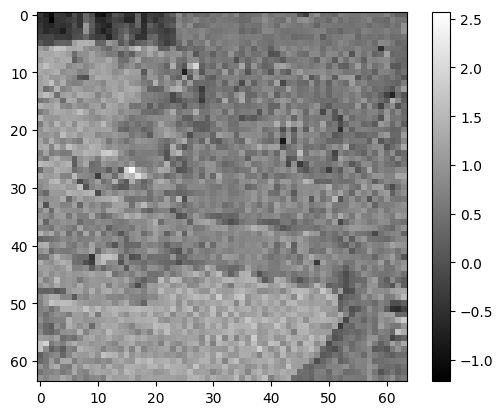

In [15]:
plot_tensor(noise[0][1])

In [16]:
output_intermediate = torch.load('/home/ms5267/blockentropy/models/output_intermediate.pth')
(hidden_states, encoder_hidden_states, temb, height_, width_) = output_intermediate

hidden_states.shape

torch.Size([2, 1024, 1536])

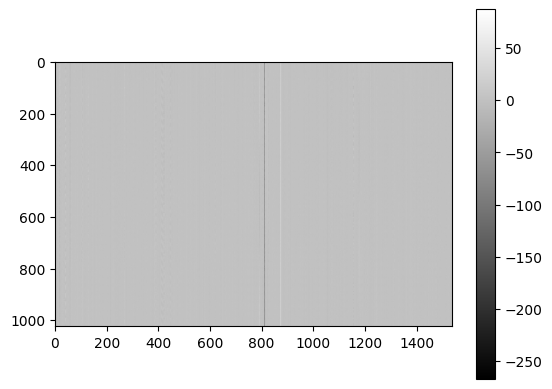

In [17]:

plot_tensor(hidden_states[1])

In [8]:
# for i in range(100,110):
# 	print(i)
# 	plot_tensor(hidden_states[1][:,i].reshape(32,32))


In [30]:
import numpy as np

'''
First layer in client done: 7.152557373046875e-07
Redundant distibuted server: 7.343292236328125e-05
Got results back from servers: 2.444096565246582
Results validated: 2.694852113723755
Redundant distibuted server: 2.709881067276001
Got results back from servers: 4.984804630279541
'''

img_512 = np.array([[5.340576171875e-05, 9.870529174804688e-05, 1.4633677005767822, 1.544633388519287, 1.545717477798462, 2.0991930961608887, 2.1099343299865723], [2.4318695068359375e-05, 4.744529724121094e-05, 0.921990156173706, 0.9709751605987549, 0.9722464084625244, 1.449342966079712, 1.4599134922027588], [4.649162292480469e-05, 8.7738037109375e-05, 0.8689780235290527, 0.9162478446960449, 0.9174723625183105, 1.332493543624878, 1.3478047847747803], [4.649162292480469e-05, 0.00011467933654785156, 1.1885197162628174, 1.2335705757141113, 1.234827995300293, 1.841332197189331, 1.8522157669067383], [4.482269287109375e-05, 8.630752563476562e-05, 1.5281033515930176, 1.5729832649230957, 1.5742628574371338, 2.147564172744751, 2.158651351928711], [4.5299530029296875e-05, 8.726119995117188e-05, 0.7520661354064941, 0.7877938747406006, 0.7888162136077881, 1.2924716472625732, 1.3069758415222168], [4.601478576660156e-05, 8.726119995117188e-05, 0.9966111183166504, 1.0420660972595215, 1.0433080196380615, 1.6133451461791992, 1.6239838600158691], [4.57763671875e-05, 8.535385131835938e-05, 0.8171277046203613, 0.862900972366333, 0.8641402721405029, 1.4452004432678223, 1.456019639968872], [4.9114227294921875e-05, 8.916854858398438e-05, 0.8773343563079834, 0.9266543388366699, 0.9279046058654785, 1.5785651206970215, 1.5895740985870361], [4.4345855712890625e-05, 0.00011157989501953125, 0.6868891716003418, 0.7403359413146973, 0.7415614128112793, 1.5958373546600342, 1.6077072620391846]])

img_1024 = np.array([[5.626678466796875e-05, 8.153915405273438e-05, 2.4442286491394043, 2.6948635578155518, 2.7099008560180664, 4.984984874725342, 5.013952970504761], [4.482269287109375e-05, 7.176399230957031e-05, 2.529268980026245, 2.664604425430298, 2.6672956943511963, 4.1680498123168945, 4.187560319900513], [2.1696090698242188e-05, 4.315376281738281e-05, 2.6765284538269043, 2.9279727935791016, 2.9430549144744873, 5.930795192718506, 5.941481590270996], [3.886222839355469e-05, 7.367134094238281e-05, 2.2054457664489746, 2.3177874088287354, 2.320474147796631, 4.597362279891968, 4.6168506145477295], [2.3365020751953125e-05, 4.506111145019531e-05, 3.6278939247131348, 3.870298385620117, 3.885544776916504, 5.363116264343262, 5.3925557136535645], [4.029273986816406e-05, 6.937980651855469e-05, 2.0099802017211914, 2.147829294204712, 2.1505377292633057, 4.533847808837891, 4.5572357177734375], [2.4557113647460938e-05, 5.0067901611328125e-05, 2.6828272342681885, 2.9068856239318848, 2.9232847690582275, 4.3148298263549805, 4.345461368560791], [5.555152893066406e-05, 9.5367431640625e-05, 3.7212467193603516, 3.85907244682312, 3.8617520332336426, 5.276211738586426, 5.283247947692871], [5.841255187988281e-05, 8.678436279296875e-05, 2.5769460201263428, 2.8196799755096436, 2.835637331008911, 4.799234867095947, 4.82965087890625], [5.054473876953125e-05, 8.821487426757812e-05, 2.190906524658203, 2.3049798011779785, 2.309156656265259, 5.034841537475586, 5.058663845062256]])

img_512_no_distribution = np.array([[3.123283386230469e-05, 6.103515625e-05, 0.718207597732544, 0.7193527221679688, 1.0720808506011963], [3.8623809814453125e-05, 7.510185241699219e-05, 0.6236252784729004, 0.6247785091400146, 0.948448657989502], [3.814697265625e-05, 7.62939453125e-05, 0.8141295909881592, 0.8152539730072021, 1.2606446743011475], [3.933906555175781e-05, 7.700920104980469e-05, 0.7255899906158447, 0.7267420291900635, 1.1158785820007324], [3.910064697265625e-05, 7.677078247070312e-05, 0.6563098430633545, 0.6574995517730713, 1.0083415508270264], [4.0531158447265625e-05, 7.915496826171875e-05, 0.6826226711273193, 0.6837763786315918, 1.0825450420379639], [7.82012939453125e-05, 0.0001354217529296875, 0.6998147964477539, 0.7009110450744629, 1.122565746307373], [3.981590270996094e-05, 8.0108642578125e-05, 0.7923924922943115, 0.7934603691101074, 1.1435468196868896], [3.8623809814453125e-05, 7.62939453125e-05, 0.6217987537384033, 0.6231598854064941, 0.9403674602508545], [4.0531158447265625e-05, 7.963180541992188e-05, 0.6532940864562988, 0.6546995639801025, 1.0192060470581055]])

img_1024_no_distribution = np.array([[2.0503997802734375e-05, 3.9577484130859375e-05, 1.5697071552276611, 1.5873019695281982, 2.924232006072998], [4.4345855712890625e-05, 7.724761962890625e-05, 1.5600895881652832, 1.5765328407287598, 2.6319830417633057], [5.364418029785156e-05, 8.058547973632812e-05, 1.7838108539581299, 1.8012034893035889, 2.9481422901153564], [7.390975952148438e-05, 0.00011420249938964844, 1.7714624404907227, 1.7889113426208496, 2.9321534633636475], [6.341934204101562e-05, 0.00011372566223144531, 1.617342233657837, 1.6344690322875977, 2.7386722564697266], [5.8650970458984375e-05, 9.679794311523438e-05, 1.5160801410675049, 1.533459186553955, 2.5688676834106445], [5.888938903808594e-05, 9.679794311523438e-05, 1.7484922409057617, 1.7662041187286377, 2.8774960041046143], [6.127357482910156e-05, 0.00011324882507324219, 1.658397912979126, 1.6748127937316895, 2.6790032386779785], [5.7220458984375e-05, 9.560585021972656e-05, 1.7755742073059082, 1.7930145263671875, 2.7523999214172363], [5.9604644775390625e-05, 0.0001125335693359375, 2.280275344848633, 2.297417402267456, 3.753577947616577]])

In [31]:
# 
print('for 512x512', np.mean(img_512,axis=0),'\n')
print('for 1024x1024', np.mean(img_1024, axis=0), '\n')

print('for img_512_no_distribution', np.mean(img_512_no_distribution,axis=0),'\n')
print('img_1024_no_distribution', np.mean(img_1024_no_distribution, axis=0))

for 512x512 [4.46081161e-05 8.95500183e-05 1.01009874e+00 1.05981615e+00
 1.06102576e+00 1.63953457e+00 1.65127804e+00] 

for 1024x1024 [4.14371490e-05 7.05003738e-05 2.66652725e+00 2.85139737e+00
 2.86066389e+00 4.90032742e+00 4.92266610e+00] 

for img_512_no_distribution [4.24146652e-05 8.16822052e-05 6.98778510e-01 6.99963403e-01
 1.07136254e+00] 

img_1024_no_distribution [5.51462173e-05 9.40322876e-05 1.72812321e+00 1.74533267e+00
 2.88065279e+00]
